In [ ]:
!pip install survivalist

Analyzing WHAS500 dataset...
Shape of X: (500, 14)
Shape of y: (500,)
Survival functions for WHAS500 dataset:


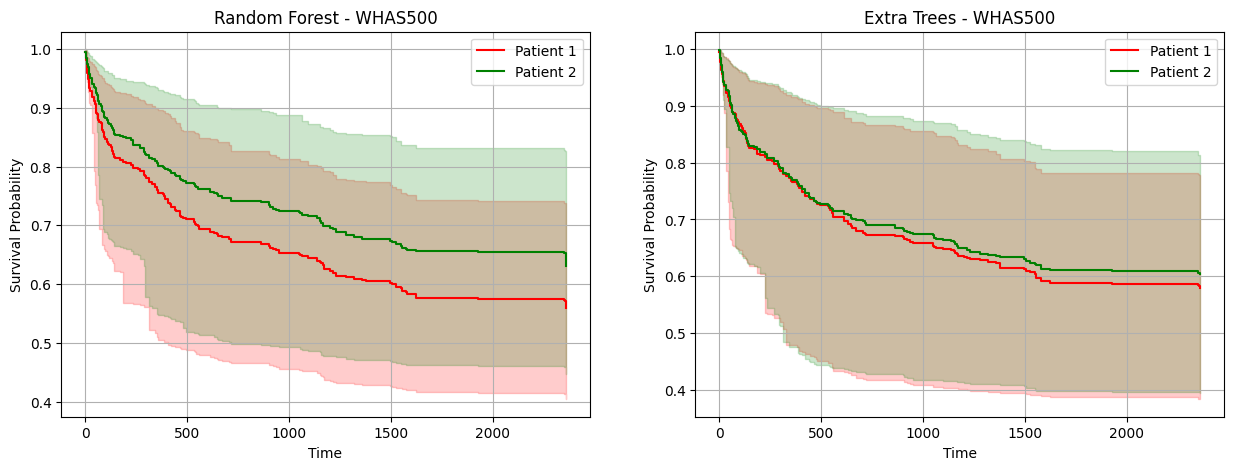


Analyzing Veterans Lung Cancer dataset...
Shape of X: (137, 11)
Shape of y: (137,)
Survival functions for Veterans dataset:


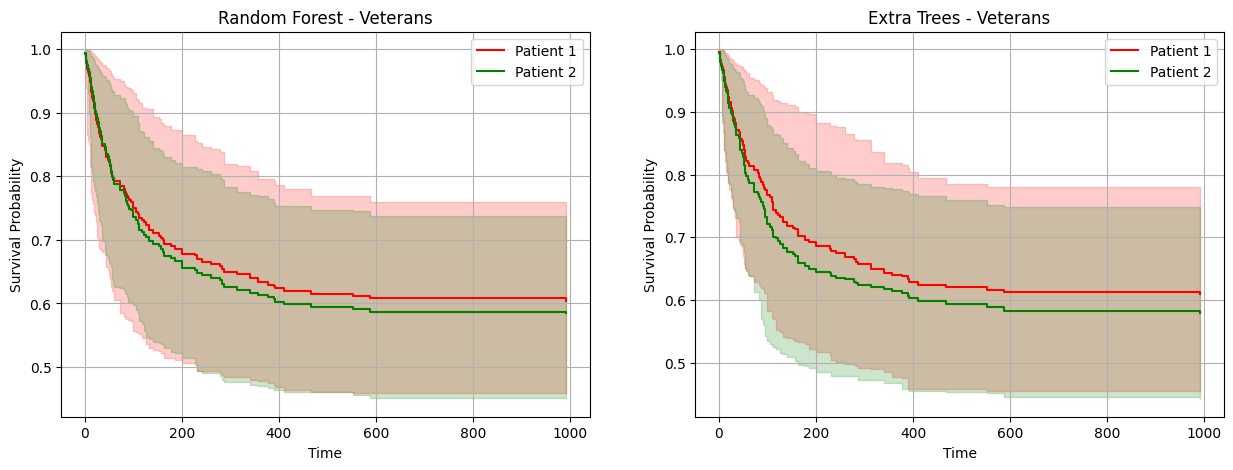

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from survivalist.datasets import load_whas500, load_veterans_lung_cancer, load_gbsg2
from survivalist.survstack import SurvStacker

import pandas as pd

def _encode_categorical_columns(df, categorical_columns=None):
    """
    Automatically identifies categorical columns and applies one-hot encoding.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with mixed continuous and categorical variables.
    - categorical_columns (list): Optional list of column names to treat as categorical.

    Returns:
    - pd.DataFrame: A new DataFrame with one-hot encoded categorical columns.
    """
    # Automatically identify categorical columns if not provided
    if categorical_columns is None:
        categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Apply one-hot encoding to the identified categorical columns
    df_encoded = pd.get_dummies(df, columns=categorical_columns)

    # Convert boolean columns to integer (0 and 1)
    bool_columns = df_encoded.select_dtypes(include=['bool']).columns.tolist()
    df_encoded[bool_columns] = df_encoded[bool_columns].astype(int)

    return df_encoded

def analyze_survival_dataset(X, y, dataset_name):
    """Analyze a survival dataset using Random Forest and Extra Trees models"""
    # Data preparation
    X = X.astype(float)
    print("Shape of X:", X.shape)
    print("Shape of y:", y.shape)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Initialize models
    survstacker_rf = SurvStacker(
        clf=RandomForestClassifier(random_state=42),
        type_sim="kde",
        loss = "ipcwls"
    )
    survstacker_et = SurvStacker(
        clf=ExtraTreesClassifier(random_state=42),
        type_sim="kde",
        loss = "ipcwls"
    )

    # Fit models
    survstacker_rf.fit(X_train, y_train)
    survstacker_et.fit(X_train, y_train)

    # Get survival function predictions with confidence intervals
    surv_funcs_rf = survstacker_rf.predict_survival_function(X_test[:2], level=80)
    surv_funcs_et = survstacker_et.predict_survival_function(X_test[:2], level=80)

    print(f"Survival functions for {dataset_name} dataset:")

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    colors = ['red', 'green', 'blue']

    # Plot RF predictions
    ax1.set_title(f'Random Forest - {dataset_name}')
    for i, (mean, lower, upper) in enumerate(zip(
        surv_funcs_rf.mean, surv_funcs_rf.lower, surv_funcs_rf.upper)):
        times = mean.x
        ax1.step(times, mean.y, where="post", label=f'Patient {i+1}', color=colors[i])
        ax1.fill_between(times, lower.y, upper.y, alpha=0.2, color=colors[i], step="post")
    ax1.grid(True)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Survival Probability')
    ax1.legend()

    # Plot ET predictions
    ax2.set_title(f'Extra Trees - {dataset_name}')
    for i, (mean, lower, upper) in enumerate(zip(
        surv_funcs_et.mean, surv_funcs_et.lower, surv_funcs_et.upper)):
        times = mean.x
        ax2.step(times, mean.y, where="post", label=f'Patient {i+1}', color=colors[i])
        ax2.fill_between(times, lower.y, upper.y, alpha=0.2, color=colors[i], step="post")
    ax2.grid(True)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Survival Probability')
    ax2.legend()

    plt.show()
    #plt.tight_layout()
    #plt.savefig(f'survival_curves_{dataset_name}.png')
    #plt.close()

# Import necessary libraries

# Analyze WHAS500 dataset
print("Analyzing WHAS500 dataset...")
X, y = load_whas500()
analyze_survival_dataset(X, y, "WHAS500")

# Analyze Veterans Lung Cancer dataset
print("\nAnalyzing Veterans Lung Cancer dataset...")
X, y = load_veterans_lung_cancer()
X = _encode_categorical_columns(X)
analyze_survival_dataset(X, y, "Veterans")

# R version

In [3]:
# prompt: load rpy2 extension

%load_ext rpy2.ipython


In [ ]:
%%R

install.packages(c("ggplot2", "gridExtra"))

In [ ]:
%%R

install.packages("reticulate")

In [ ]:
%%R

library(reticulate)

system("pip uninstall -y survivalist")
system("pip install survivalist --upgrade --no-cache-dir --verbose")

# Import Python modules (/!\ this will work if the Python packages are in the environment, e.g in Colab)
np <- import("numpy")
pd <- import("pandas")
lgb <- import("lightgbm")
xgb <- import("xgboost")
survivalist <- import("survivalist")
sklearn <- import("sklearn")

In addition: Warning message:
Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


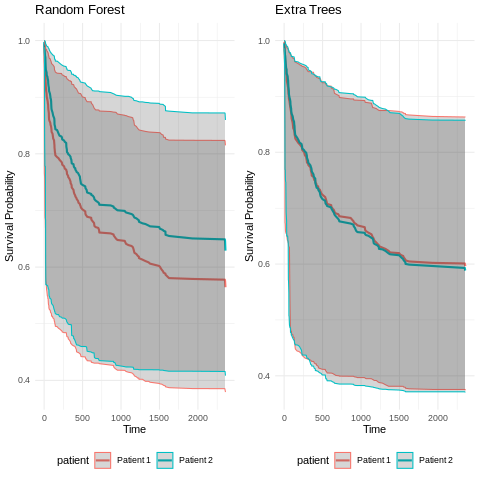

In [7]:
%%R

# Load reticulate and install survivalist if needed
library(reticulate)
library(ggplot2)
library(gridExtra)

# Import Python modules using reticulate
np <- import("numpy")
pd <- import("pandas")
plt <- import("matplotlib.pyplot")
sklearn <- import("sklearn")
survivalist <- import("survivalist")

# Load WHAS500 dataset (replace with load_veterans_lung_cancer() for other datasets)
data <- survivalist$datasets$load_whas500()
X <- data[[1]]  # Features (Python object)
y <- data[[2]]  # Survival targets (Python object)

# Function to encode categorical columns (e.g., for Veterans Lung Cancer)
encode_categorical_columns <- function(df_py) {
  pd$get_dummies(r_to_py(df_py))  # Convert to R, encode, return Python object
}

# Split data in Python (avoid unnecessary R conversions)
train_test_split <- sklearn$model_selection$train_test_split
split_result <- train_test_split(
  X, y,
  test_size = 0.2,
  random_state = 42L
)

# Extract X_train, X_test, y_train, y_test (Python objects)
X_train <- split_result[[1]]
X_test  <- split_result[[2]]
y_train <- split_result[[3]]
y_test  <- split_result[[4]]

# Initialize and train SurvStacker models
SurvStacker <- survivalist$survstack$SurvStacker
rf_model <- SurvStacker(
  clf = sklearn$ensemble$RandomForestClassifier(random_state = 42L),
  type_sim = "kde",
  loss = "ipcwls"
)
et_model <- SurvStacker(
  clf = sklearn$ensemble$ExtraTreesClassifier(random_state = 42L),
  type_sim = "kde",
  loss = "ipcwls"
)

# Fit models
rf_model$fit(X_train, y_train)
et_model$fit(X_train, y_train)

# Predict survival functions with 95% confidence intervals
surv_funcs_rf <- rf_model$predict_survival_function(X_test[0:2, ], level = 95)
surv_funcs_et <- et_model$predict_survival_function(X_test[0:2, ], level = 95)

# Convert Python survival functions to R lists
parse_surv_func <- function(surv_func) {
  lapply(seq_along(py_to_r(surv_func$mean)), function(i) {
    mean <- surv_func$mean[[i]]
    lower <- surv_func$lower[[i]]
    upper <- surv_func$upper[[i]]
    data.frame(
      time = unlist(mean$x),
      mean = unlist(mean$y),
      lower = unlist(lower$y),
      upper = unlist(upper$y),
      patient = paste0("Patient ", i)
    )
  })
}

rf_list <- parse_surv_func(surv_funcs_rf)
et_list <- parse_surv_func(surv_funcs_et)

# Plot survival curves using ggplot2
plot_survival_curves <- function(data_list, title) {
  df <- do.call(rbind, data_list)
  ggplot(df, aes(x = time, color = patient)) +
    geom_line(aes(y = mean), size = 1) +
    geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.2) +
    labs(title = title, x = "Time", y = "Survival Probability") +
    theme_minimal() +
    theme(legend.position = "bottom")
}

p1 <- plot_survival_curves(rf_list, "Random Forest")
p2 <- plot_survival_curves(et_list, "Extra Trees")
grid.arrange(p1, p2, ncol = 2)